<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#label-dictionary" data-toc-modified-id="label-dictionary-1">label dictionary</a></span></li><li><span><a href="#make-tfrecord" data-toc-modified-id="make-tfrecord-2">make tfrecord</a></span></li><li><span><a href="#decode-check" data-toc-modified-id="decode-check-3">decode check</a></span></li></ul></div>

In [1]:
import os
import glob
import json
from tqdm.notebook import tqdm
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
base_dir = os.getenv("HOME") + "/UDIGO"

In [3]:
folder_list = glob.glob(base_dir + "/dataset/train/*")
num_classes = len(folder_list)
num_classes

55

# label dictionary

In [4]:
save_dir = os.path.join(base_dir, "data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
label_df = pd.read_csv(save_dir + "/category.csv").iloc[:, :2]
label_df.head()

,id,category
0,1,공원
1,2,공항
2,3,놀이공원
3,4,다리
4,5,미술관


In [6]:
label_id = label_df.to_dict('index')
label_id

{0: {'id': 1, 'category': '공원'},
 1: {'id': 2, 'category': '공항'},
 2: {'id': 3, 'category': '놀이공원'},
 3: {'id': 4, 'category': '다리'},
 4: {'id': 5, 'category': '미술관'},
 5: {'id': 6, 'category': '볼링장'},
 6: {'id': 7, 'category': '산'},
 7: {'id': 8, 'category': '아이스링크'},
 8: {'id': 9, 'category': '아쿠아리움'},
 9: {'id': 10, 'category': '호텔'},
 10: {'id': 11, 'category': '궁궐'},
 11: {'id': 12, 'category': '지하철역'},
 12: {'id': 13, 'category': '놀이터'},
 13: {'id': 14, 'category': '수영장'},
 14: {'id': 15, 'category': '폭포'},
 15: {'id': 16, 'category': '동물원'},
 16: {'id': 17, 'category': '절'},
 17: {'id': 18, 'category': '교회'},
 18: {'id': 19, 'category': '성당'},
 19: {'id': 20, 'category': '시장'},
 20: {'id': 21, 'category': '쇼핑몰'},
 21: {'id': 22, 'category': '클럽'},
 22: {'id': 23, 'category': '박물관'},
 23: {'id': 24, 'category': '축구장'},
 24: {'id': 25, 'category': '야구장'},
 25: {'id': 26, 'category': '농구장'},
 26: {'id': 27, 'category': '공연장'},
 27: {'id': 28, 'category': '베이커리'},
 28: {'id': 29, 'c

In [7]:
label_dict = {}
for i in range(len(label_id)):
    label_dict[label_id[i]['id']] = label_id[i]['category']

In [8]:
label_dict

{1: '공원',
 2: '공항',
 3: '놀이공원',
 4: '다리',
 5: '미술관',
 6: '볼링장',
 7: '산',
 8: '아이스링크',
 9: '아쿠아리움',
 10: '호텔',
 11: '궁궐',
 12: '지하철역',
 13: '놀이터',
 14: '수영장',
 15: '폭포',
 16: '동물원',
 17: '절',
 18: '교회',
 19: '성당',
 20: '시장',
 21: '쇼핑몰',
 22: '클럽',
 23: '박물관',
 24: '축구장',
 25: '야구장',
 26: '농구장',
 27: '공연장',
 28: '베이커리',
 29: '키즈카페',
 30: '숲',
 31: '캠핑장',
 32: '식물원',
 33: '해수욕장',
 34: '수상레포츠',
 35: '미용실',
 36: 'PC방',
 37: '도서관',
 38: '컨벤션센터',
 39: '대학교',
 40: '패스트푸드점',
 41: '골프장',
 42: '헬스장',
 43: '병원',
 44: '빨래방',
 45: '찜질방',
 46: '스키장',
 47: '워터파크',
 48: '한옥마을',
 49: '롯데월드타워',
 50: '남산서울타워',
 51: '동대문디자인플라자',
 52: '63빌딩',
 53: '국회의사당',
 54: '청와대',
 55: '세빛섬'}

In [9]:
with open(save_dir + f"/place_{num_classes}_label.json", "w") as json_file:
    json.dump(label_dict, json_file)

In [10]:
label_dict_re = {v:k for k,v in label_dict.items()}
with open(save_dir + f"/place_{num_classes}_label_to_id.json", "w") as json_file:
    json.dump(label_dict_re, json_file)

# make tfrecord

In [12]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [13]:
def make_tfrecord(img_path, 
                  tfr_path, 
                  num_classes=num_classes, 
                  img_size=224, 
                  is_train=True):
    
    image_list = glob.glob(img_path)
    num_images = len(image_list)
    
    writer = tf.io.TFRecordWriter(tfr_path)
    n = 0

    for img in tqdm(image_list):
        try:
            image = cv2.imread(img, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_to_byte = image.tobytes()

            label = img.split("/")[-3 if is_train else -2]
            label_encoding = label_dict_re[label]

            example = tf.train.Example(features=tf.train.Features(feature={
                "image" : _bytes_feature(image_to_byte),
                "label" : _int64_feature(label_encoding)
            }))

            writer.write(example.SerializeToString())
            n += 1
        
        except:
            print("Invalid image:", img)
            continue

    writer.close()
    print(f"{n} data, TFRecord saved!")
    return n

In [14]:
n_train = make_tfrecord(base_dir + "/dataset/train/*/*/*", 
                        base_dir + f"/data/place_{num_classes}_train.tfr", 
                        is_train=True)

Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/수영장/c02_01_04_img2.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/수영장/c02_04_04_img1.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/수영장/facil_intro02.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/수영장/1513145177337_36103fc5a6d9429c90c4d9d033df365e.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/crawling/img01_swimming.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/crawling/pic_01_01.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/banana_boat179
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/yacht449.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/water_skiing145.gif?type=w966
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/barefoot_ski137.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/surfing_board454.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수상레포츠/crawling/water_zet_skiing230.gif
Invalid image

In [15]:
n_val = make_tfrecord(base_dir + "/dataset/val/*/*", 
                      base_dir + f"/data/place_{num_classes}_val.tfr", 
                      is_train=False)

Invalid image: /home/ssac21/UDIGO/dataset/val/수영장/img04_01_01_01.gif
Invalid image: /home/ssac21/UDIGO/dataset/val/수상레포츠/one-footed_skiing063.gif?type=w580
Invalid image: /home/ssac21/UDIGO/dataset/val/폭포/143945859.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/아쿠아리움/IxTfFr0HtNhncMXgbW-_KfF1MQVk.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/다리/han_bridge537.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/롯데월드타워/lotte_tower344
Invalid image: /home/ssac21/UDIGO/dataset/val/궁궐/a7f8095cc8bcc152408ac37a384ce5d3.gif

21516 data, TFRecord saved!


In [16]:
os.rename(base_dir + f"/data/place_{num_classes}_train.tfr", 
          base_dir + f"/data/place_{num_classes}_{n_train}_train.tfr")
os.rename(base_dir + f"/data/place_{num_classes}_val.tfr", 
          base_dir + f"/data/place_{num_classes}_{n_val}_val.tfr")

# decode check

In [17]:
tfr_path = base_dir + f"/data/place_{num_classes}_{n_train}_train.tfr"
dataset = tf.data.TFRecordDataset(tfr_path)

In [18]:
features = {'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
           }

In [19]:
def _parse_image(example):
    return tf.io.parse_single_example(example, features)

parsed_dataset = dataset.map(_parse_image)

tf.Tensor(7, shape=(), dtype=int64)


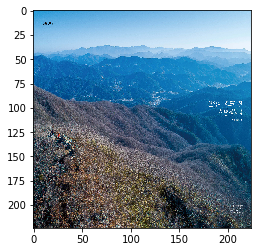

tf.Tensor(7, shape=(), dtype=int64)


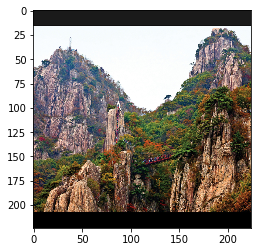

tf.Tensor(7, shape=(), dtype=int64)


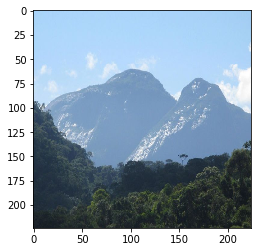

tf.Tensor(7, shape=(), dtype=int64)


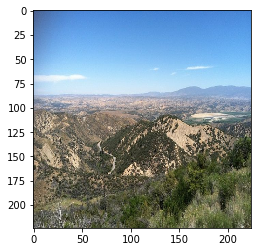

tf.Tensor(7, shape=(), dtype=int64)


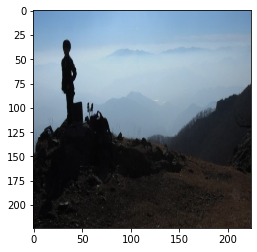

In [20]:
for data in parsed_dataset.take(5):
    print(data['label'])
    image_raw = tf.io.decode_raw(data['image'], tf.uint8)
    image_raw = tf.reshape(image_raw, [224, 224, 3])
    plt.imshow(image_raw)
    plt.show()